In [1]:
import warnings
warnings.filterwarnings('ignore')

import graphviz
import os
import numpy as np
import pandas as pd
from preprocess_data import preprocess_titanic_data

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df_trn, df_tst = preprocess_titanic_data(df)

In [4]:
df_trn.head()

,SibSp,Parch,Fare,Age,Pclass,Sex,Survived
276,0.0,0.0,7.7500,group3,3,female,0
366,1.0,0.0,75.2500,group4,1,female,1
257,0.0,0.0,86.5000,group3,1,female,1
824,4.0,1.0,39.6875,group1,3,male,0
766,0.0,0.0,39.6000,group2,1,male,0


In [5]:
df_tst.head()

,SibSp,Parch,Fare,Age,Pclass,Sex,Survived
184,0.0,2.0,22.0250,group1,3,female,1
874,1.0,0.0,24.0000,group2,2,female,1
628,0.0,0.0,7.8958,group2,3,male,0
637,1.0,1.0,26.2500,group3,2,male,0
747,0.0,0.0,13.0000,group3,2,female,1


In [6]:
df_trn['Age'] = df_trn['Age'].apply(lambda x: x[-1])
df_tst['Age'] = df_tst['Age'].apply(lambda x: x[-1])

In [7]:
sex_dict = {'female': '0', 'male': '1'}
df_trn['Sex'] = df_trn['Sex'].apply(lambda x: sex_dict[x])
df_tst['Sex'] = df_tst['Sex'].apply(lambda x: sex_dict[x])

In [8]:
df_trn['Pclass'] = df_trn['Pclass'].astype('O')
df_tst['Pclass'] = df_tst['Pclass'].astype('O')
df_trn['Age'] = df_trn['Age'].astype('O')
df_tst['Age'] = df_tst['Age'].astype('O')
df_trn['Sex'] = df_trn['Sex'].astype('O')
df_tst['Sex'] = df_tst['Sex'].astype('O')

<span style = 'font-size:1.3em;line-height:1.5em'><b>1. </b>위와 같이 전처리된 Titanic dataset을 활용하여 Decision Tree 모델을 학습하고자 합니다. 다음 Process를 수행하세요.</span>
- <span style = 'font-size:1.2em;line-height:1.5em'><b>(1) </b>5-fold Cross validation을 수행했을 때, 평균 accuracy를 구하세요.</span>
- <span style = 'font-size:1.2em;line-height:1.5em'><b>(2) </b>아래 `params`라는 dict에 들어있는 hyperparameter 중, 최적의 조합을 찾고자 합니다.(Random하게) Accuracy를 기준으로 하였을 때, 최적의 model을 찾으세요. 또한, 최적의 모델을 test set(`df_tst`)에 활용하였을 때, accuracy를 구하세요.</span>
- <span style = 'font-size:1.2em;line-height:1.5em'><b>(3) </b>최적 Decision Tree model을 graphviz를 활용하여 시각화하세요.</span>
- <span style = 'font-size:1.2em;line-height:1.5em'><b>(4) </b>변수 중요도를 구하세요./span>

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

### (1) 5-fold Cross validation을 수행했을 때, 평균 accuracy

In [10]:
model = DecisionTreeClassifier()
scores = cross_val_score(model, X=df_trn.iloc[:,:-1], y=df_trn.iloc[:,-1])
print(f"평균 CV accuracy: {np.mean(scores):.3f}")

평균 CV accuracy: 0.785


In [11]:
scores

array([0.7972028 , 0.79020979, 0.8028169 , 0.76056338, 0.77464789])

### (2) 최적 hyperparameter조합을 찾고, 해당 모델을 test set에 활용했을 때 accuracy 구하기

In [12]:
params = {
    'criterion': ['entropy', 'gini'],
    'splitter': ['random', 'best'],
    'max_depth': [None,2,3,4,5],
    'min_samples_split': [2,3,4,5,6,8,10],
    'max_leaf_nodes': [None, 3,6,9,12],
    'min_impurity_decrease': [0.0, 0.0005, 0.005, 0.05, 0.1, 0.15, 0.2]
}

In [13]:
model = DecisionTreeClassifier()
rand_clf = RandomizedSearchCV(model, params, n_iter=20, cv=5)
rand_clf.fit(X=df_trn.iloc[:,:-1], y=df_trn.iloc[:,-1])
best_model = rand_clf.best_estimator_
best_score = rand_clf.best_score_

print(f"The best performance (in CV) is {best_score:.3f}")

The best performance (in CV) is 0.824


- <span style = 'font-size:1.2em;line-height:1.5em'>최적의 parameter 조합으로 만들어진 모델을 test set에 적용했을 때 성능 측정하기</span>

In [14]:
y_pred = best_model.predict(df_tst.iloc[:,:-1])
y_true = df_tst.iloc[:,-1]
acc = accuracy_score(y_true = y_true, y_pred=y_pred)
print(f"The accuracy score of the selected model in the test set is {acc:.3f}")

The accuracy score of the selected model in the test set is 0.838


In [15]:
confusion_matrix(y_true, y_pred)

array([[95, 15],
       [14, 55]], dtype=int64)

### Decision Tree 시각화하기

In [16]:
from sklearn.tree import export_graphviz

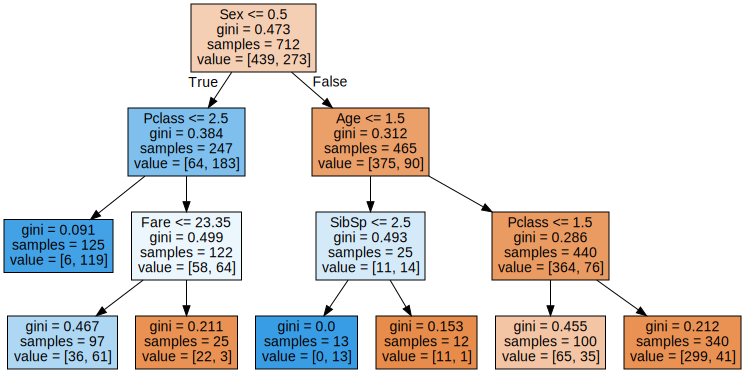

In [17]:
model_dir = 'model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
export_graphviz(best_model, 
                out_file=f'{model_dir}/tree4.dot', 
#                 class_names=iris.target_names, 
                feature_names=[col for col in df_trn.columns if col != 'Survived'], 
                impurity=True, 
                filled=True)

with open(f'{model_dir}/tree4.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### 변수 중요도 확인하기

In [18]:
feature_dict = dict(zip([col for col in df.columns if col != 'Survived'], best_model.feature_importances_))

In [19]:
import operator
sorted(feature_dict.items(), key = operator.itemgetter(1), reverse=True)

[('SibSp', 0.6226819281566287),
 ('Age', 0.19772552891370265),
 ('PassengerId', 0.06755940086321775),
 ('Name', 0.0663188623086861),
 ('Sex', 0.04571427975776482),
 ('Pclass', 0.0)]

- <span style = 'font-size:1.2em;line-height:1.5em'>조금 더 이쁘게 그림으로 표기하도록 하겠습니다.</span>

<AxesSubplot:>

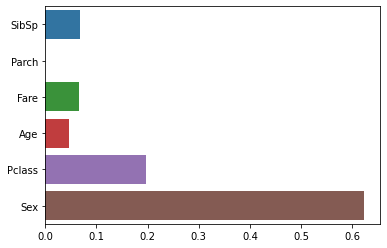

In [20]:
import seaborn as sns
%matplotlib inline

sns.barplot(x=best_model.feature_importances_, y=[col for col in df_trn.columns if col != 'Survived'])